<a href="https://www.kaggle.com/code/samudra89/01-customer-segmentation-bank-transactions?scriptVersionId=141301365" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Customer Segmentation

Customer segmentation is a crucial business strategy that categorizes an organization's customers into distinct groups based on shared characteristics. By analyzing customer behaviour and interactions with the company's services, businesses aim to identify patterns and preferences within each group. It enables them to tailor their services, develop more effective marketing strategies, and provide personalized experiences to meet the unique needs of each customer segment.

There are four primary types of customer segmentation:

1. Geographical: Based on customers' locations and regions.
2. Demographical: Segmentation by age, gender, and income of customers.
3. Behavioural: Categorizing customers according to their purchasing occasions, loyalty, and satisfaction levels.
4. Psychological: Segmentation according to customers' lifestyle, beliefs, and social status.

Among various ML algorithms, the Hidden Markov Model (HMM) and different clustering algorithms are particularly popular choices for addressing customer segmentation challenges.

In this exercise, my primary focus will be on K-means clustering. K-Means is a heuristic algorithm used for clustering data based on a measure of closeness. It groups data into K clusters, where K represents the number of desired clusters. The algorithm works iteratively by moving the centroids (cluster centres) to the mean position of their constituent points and reassigning data instances to their closest clusters. This process continues iteratively until no significant change in the cluster centres is possible, leading to the convergence of the algorithm.

### Dataset Description:
This extensive dataset comprises over 1 Million transactions made by more than 800K customers for a bank in India. The data represents various key details, including customer age (DOB), location, gender, account balance during the transaction, transaction specifics, transaction amounts, and more.

### Interesting Analysis Ideas:
The dataset offers diverse possibilities for analysis, such as:

1. Clustering / Segmentation: Utilize clustering algorithms to group customers based on shared characteristics, discover popular customer segments and define their unique traits and behaviours.
2. Location-wise Analysis: Perform region-specific analysis to uncover trends and patterns in different parts of India, based on regional variations and preferences.
3. Transaction-related Analysis: Explore into transaction data to identify trends that can enhance and optimize user experiences, assisting the bank in making informed improvements to its services.
4. Customer Recency, Frequency, Monetary (RFM) Analysis: Analyze customer behaviour in terms of recency of transactions, transaction frequency, and monetary value, helping the bank better understand customer engagement and spending patterns.

### Data Exploration

In [1]:
import numpy as np 
import pandas as pd 


import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import time

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer 
from mpl_toolkits.mplot3d import Axes3D


/kaggle/input/bank-customer-segmentation/bank_transactions.csv
/kaggle/input/india-district-wise-shape-files/output.prj
/kaggle/input/india-district-wise-shape-files/output.dbf
/kaggle/input/india-district-wise-shape-files/output.shx
/kaggle/input/india-district-wise-shape-files/output.shp
/kaggle/input/india-district-wise-shape-files/output.cpg


In [2]:
data = pd.read_csv('/kaggle/input/bank-customer-segmentation/bank_transactions.csv')
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


The following provide a quick overview of the dataset at hand. There are 9 different attributes that are represented in the columns of the data. Some of them are transaction related while the others are customer related information.

In [3]:
data.shape

(1048567, 9)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


#### Check for missing values

Here, we mainly look at the percentage of missing values. If the amount is too small we can ignore that data. If there are lots of missing values we may need to apply some missing value imputation method to complete the data. Since the null value percentage is less than 0.5% for each column, I dropped those with null values.

In [5]:
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
TransactionID,TransactionID,0.000000
CustomerID,CustomerID,0.000000
CustomerDOB,CustomerDOB,0.323966
CustGender,CustGender,0.104905
CustLocation,CustLocation,0.014401
CustAccountBalance,CustAccountBalance,0.225927
TransactionDate,TransactionDate,0.000000
TransactionTime,TransactionTime,0.000000
TransactionAmount (INR),TransactionAmount (INR),0.000000


In [6]:
df=data.dropna()

In the 'CustomerDOB' column, there are several obsolete values, such as 56292 entries with the birthday listed as 1/1/1800. To ensure a clean and up-to-date dataset, I will proceed with removing these obsolete entries.

In [7]:
df['CustomerDOB'].value_counts()

1/1/1800    56292
1/1/89        809
1/1/90        784
6/8/91        698
1/1/91        665
            ...  
2/12/51         1
20/3/52         1
26/9/47         1
4/10/41         1
24/10/44        1
Name: CustomerDOB, Length: 17233, dtype: int64

In [8]:
df=df.loc[df['CustomerDOB']!='1/1/1800']

In [9]:
#df['TransactionDate'].value_counts()


Next, I will proceed with the following data processing steps:

1. Convert the date columns to the datetime type for better analysis.
2. Remove all transactions that have a Date of Birth (DOB) date larger than the latest transaction date in the dataset.
3. Introduce a new column that calculates the 'age' attribute for each customer. Age will be computed using the provided date of birth and the latest transaction date available in the dataset.

In [10]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'])

In [11]:
print(df['TransactionDate'].max(), df['TransactionDate'].min())

2016-12-09 00:00:00 2016-01-08 00:00:00


In [12]:
print(df['CustomerDOB'].max(), df['CustomerDOB'].min())

2072-12-31 00:00:00 1973-01-01 00:00:00


In [13]:
df=df.loc[df['CustomerDOB']< df['TransactionDate'].max()]

In [14]:
def age(born):
    return max_trn.year - born.year - ((max_trn.month, 
                                      max_trn.day) < (born.month, 
                                                    born.day))

max_trn = df['TransactionDate'].max()
df['Age'] = df['CustomerDOB'].apply(age)

In [15]:
df.head(3)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Age
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25.0,22
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,142712,459.0,20
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,142714,2060.0,43


### Exploratory Data Analysis (EDA)


Following the initial data exploration and cleaning process, I moved to the exploratory data analysis (EDA) phase. During this stage, my focus was on studying the distributions of several interesting attributes, including age, gender, and the geographic spread of bank customers across India. Additionally, I explored the potential relationships between these attributes to gain insights into customer behaviour.

To effectively group the data, I also identified and examined the unique attributes available in the dataset. These unique characteristics hold significance in facilitating the process of data grouping and segmentation for further analysis.

<AxesSubplot:xlabel='Age', ylabel='Count'>

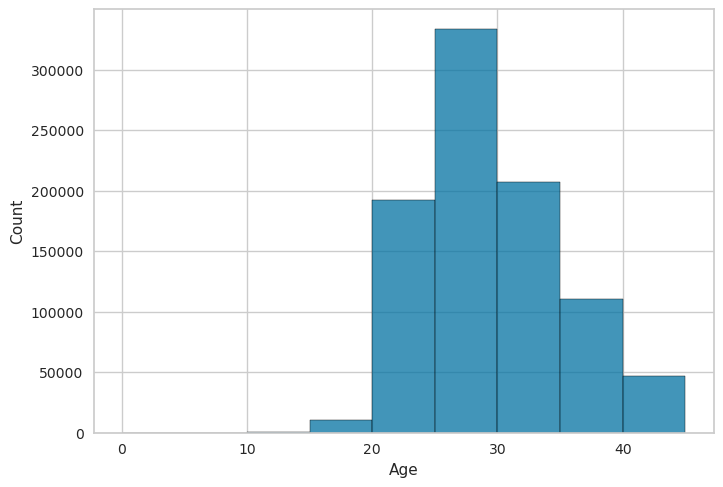

In [16]:
sns.histplot(data=df, x="Age", binwidth=5)

<AxesSubplot:xlabel='CustGender', ylabel='Count'>

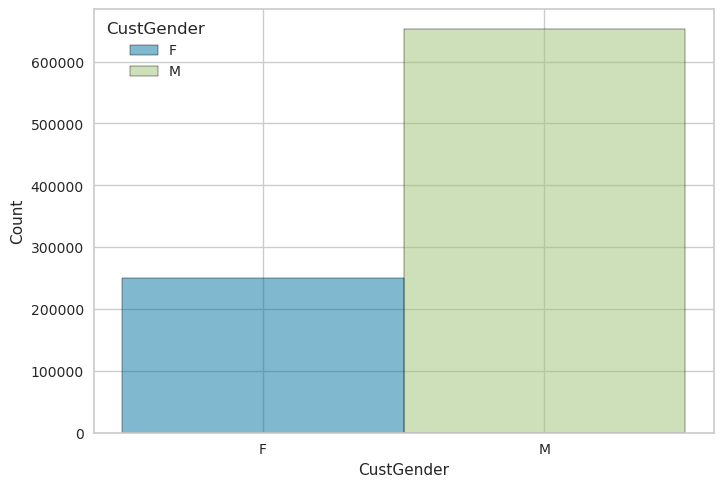

In [17]:
sns.histplot(data=df, x="CustGender", hue="CustGender")

<AxesSubplot:xlabel='Age', ylabel='TransactionAmount (INR)'>

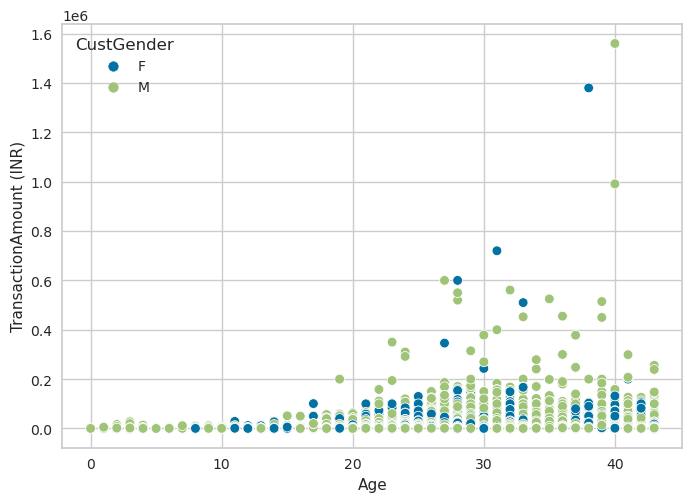

In [18]:
sns.scatterplot(data=df, x= 'Age', y='TransactionAmount (INR)', hue='CustGender')

In [19]:
df['CustLocation'].value_counts()

MUMBAI                89156
BANGALORE             72259
NEW DELHI             67791
GURGAON               64564
DELHI                 61763
                      ...  
(E) THANE SECTOR 3        1
MANIMANGALAM              1
CHINCHINIM                1
PEN DIST RAIGAD           1
IMPERIA THANE WEST        1
Name: CustLocation, Length: 7643, dtype: int64


Based on the observations from the above plots, we can draw several conclusions:

1. Age Distribution: The majority of bank transactions are carried out by individuals between the ages of 20 and 45. This age group appears to be the most active in terms of financial activities.
2. Gender Distribution: The data shows that the number of male customers is larger than the number of female customers. This indicates that the bank's customer base is predominantly male.
3. Transaction Volume: Male customers have conducted a higher number of transactions compared to female customers. This suggests that male customers are more frequently engaged in financial transactions.
4. Relationship between Age, Gender, and Transaction Amount: The final linear plot illustrates the relationship between age groups, gender, and transaction amounts. It reveals that the highest transaction amounts are associated with customers older than 30 years, and, the majority of these high-value transactions are carried out by male customers.
5. Geographic Distribution: The data reveals a total of 7643 different customer locations. Among these, the cities with the highest number of customers are Mumbai, Bangalore, New Delhi, Gurgaon, and Delhi. These cities represent some of the most densely populated and economically significant regions in India.

In summary, the analysis of the plots provides valuable insights into the bank's customer demographics, transaction patterns, and geographic concentration. Understanding these trends can help the bank make informed decisions and tailor their services to better meet the needs of its diverse customer base, particularly in key urban centres.

In [20]:
#df.groupby(['CustomerID'])['TransactionID'].count().reset_index(name='counts').sort_values(by='counts', ascending=False)

In [21]:
#df.groupby(['CustomerID'])['TransactionAmount (INR)'].sum().reset_index(name='total amount').sort_values(by='total amount', ascending=False)

In [22]:
df.loc[df['CustomerID']== 'C2140114']

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Age
241841,T241842,C2140114,1992-03-07,M,BANGALORE,6512.7,2016-07-08,160832,20.0,24
622580,T622581,C2140114,1992-03-07,M,BANGALORE,6512.7,2016-08-29,221235,30.0,24
681556,T681557,C2140114,1992-03-07,M,BANGALORE,6512.7,2016-08-30,211016,30.0,24


In [23]:
df.groupby(['CustomerID','CustomerDOB', 'CustGender', 'CustLocation'])['TransactionDate'].count().reset_index(name='counts').sort_values(by='counts', ascending=False)

,CustomerID,CustomerDOB,CustGender,CustLocation,counts
130662,C2140114,1992-03-07,M,BANGALORE,3
308753,C3741055,1991-05-23,M,SHAHEED BHAGAT SINGH NGR NAWANSHAHR,3
47964,C1422287,1989-09-17,M,PAONTA SAHIB,3
26655,C1224627,1990-07-01,M,NO 3 NR LALLAN HOTEL THANE,3
428308,C4832372,1991-09-30,F,MUMBAI,2
...,...,...,...,...,...
300279,C3711862,1978-09-14,M,NEW DELHI,1
300280,C3711862,1985-04-11,M,BANGALORE,1
300281,C3711864,1986-07-04,F,NOIDA,1
300282,C3711864,1991-09-13,M,BANGALORE,1


### RFM analysis

Based on the transaction data available, we can implement either behavioural or biographical-based customer segmentation. However, given that transaction patterns play a more significant role in the data, I have decided to proceed with RFM (Recency, Frequency, Monetary) analysis, which is a behaviour-based customer segmentation technique. RFM analysis involves categorizing customers into groups based on their previous transaction patterns. Let's look into how we can calculate the following key metrics:

**Recency (R):** This metric focuses on identifying customers who have made recent purchases. To calculate Recency, we determine the number of days since a customer's last purchase, with lower values indicating the least recency.

**Frequency (F):** The Frequency metric helps identify customers who make frequent purchases. It involves calculating the total number of purchases made by each customer, with higher values indicating a higher frequency of purchases.

**Monetary Value (M):** The Monetary Value metric enables us to pinpoint customers with high purchase amounts. It involves calculating the total amount of money spent by each customer, with higher values indicating a higher monetary value of purchases.

By utilizing these RFM metrics, we can effectively segment the customers and gain valuable insights into their transaction behaviours.

### Method 1

Calculate RMF values altogether.

In [24]:
# This code snippet calculate the RMF values altogether, You can also calculate them one by one
start = time.time()

#Convert ORDERDATE to datetime format.
RFM_data = df[['TransactionID','CustomerID','CustomerDOB', 'CustGender', 'CustLocation','TransactionDate', 'TransactionAmount (INR)']]
# RFM Table
RFM_table=RFM_data.groupby(['CustomerID','CustomerDOB', 'CustGender', 'CustLocation']).agg({'TransactionDate': lambda x: (max_trn - x.max()).days, # Recency
                                                'TransactionID': lambda x: len(x.unique()), # Frequency
                                                'TransactionAmount (INR)': lambda x: x.sum()}).reset_index()    # Monetary 

RFM_table.rename(columns={'TransactionDate': 'recency', 
                         'TransactionID': 'frequency',
                         'TransactionAmount (INR)': 'monetary_value'}, inplace=True)


end = time.time()
print(end - start)

RFM_table.head()

230.60283398628235


,CustomerID,CustomerDOB,CustGender,CustLocation,recency,frequency,monetary_value
0,C1010011,1983-05-08,M,NEW DELHI,92,1,356.0
1,C1010011,1992-08-19,F,NOIDA,74,1,4750.0
2,C1010012,1994-07-28,M,MUMBAI,117,1,1499.0
3,C1010014,1984-08-19,M,MUMBAI,154,1,250.0
4,C1010014,1992-04-06,F,MUMBAI,336,1,1205.0


In [25]:
RFM_table.loc[RFM_table['CustomerID']=='C1010011']

,CustomerID,CustomerDOB,CustGender,CustLocation,recency,frequency,monetary_value
0,C1010011,1983-05-08,M,NEW DELHI,92,1,356.0
1,C1010011,1992-08-19,F,NOIDA,74,1,4750.0


In [26]:
#RFM_table['frequency'].unique()

### Method 2

Calculate RMF values seperately.

#### Calculate recency


In [27]:
sel_feat_df = df[['CustomerID','CustGender', 'CustomerDOB','CustLocation', 'CustAccountBalance', 'TransactionDate', 'TransactionAmount (INR)', 'Age']]

In [28]:
sel_feat_df.head(3)

,CustomerID,CustGender,CustomerDOB,CustLocation,CustAccountBalance,TransactionDate,TransactionAmount (INR),Age
0,C5841053,F,1994-10-01,JAMSHEDPUR,17819.05,2016-02-08,25.0,22
2,C4417068,F,1996-11-26,MUMBAI,17874.44,2016-02-08,459.0,20
3,C5342380,F,1973-09-14,MUMBAI,866503.21,2016-02-08,2060.0,43


In [29]:
sel_feat_df=sel_feat_df.copy()
sel_feat_df.loc[:,('rank')] = sel_feat_df.sort_values(['CustomerID','TransactionDate']).groupby(['CustomerID','CustomerDOB', 'CustGender', 'CustLocation'])['TransactionDate'].rank(ascending=False).astype(int)
df_rec = sel_feat_df.loc[sel_feat_df['rank']==1]

In [30]:
#sel_feat_df.loc[sel_feat_df['CustomerID']== 'C2140114']


In [31]:
df_rec=df_rec.copy()
df_rec.loc[:,('recency')] = (df_rec['TransactionDate'].max() - df_rec['TransactionDate']).dt.days

In [32]:
df_rec.head(3)

,CustomerID,CustGender,CustomerDOB,CustLocation,CustAccountBalance,TransactionDate,TransactionAmount (INR),Age,rank,recency
0,C5841053,F,1994-10-01,JAMSHEDPUR,17819.05,2016-02-08,25.0,22,1,305
2,C4417068,F,1996-11-26,MUMBAI,17874.44,2016-02-08,459.0,20,1,305
3,C5342380,F,1973-09-14,MUMBAI,866503.21,2016-02-08,2060.0,43,1,305


In [33]:
#df_rec.loc[df_rec['CustomerID']== 'C1010011']

#### Calculate frequency

In [34]:
df_freq = sel_feat_df.groupby(['CustomerID','CustomerDOB', 'CustGender', 'CustLocation'])['TransactionDate'].count().reset_index(name='frequency')
# df_freq = pd.DataFrame(freq).reset_index()
# df_freq.columns = ['CustomerID','frequency']

In [35]:
rec_freq = df_freq.merge(df_rec,on=['CustomerID','CustomerDOB', 'CustGender', 'CustLocation'])
rec_freq.head(3)

,CustomerID,CustomerDOB,CustGender,CustLocation,frequency,CustAccountBalance,TransactionDate,TransactionAmount (INR),Age,rank,recency
0,C1010011,1983-05-08,M,NEW DELHI,1,120180.54,2016-09-08,356.0,33,1,92
1,C1010011,1992-08-19,F,NOIDA,1,32500.73,2016-09-26,4750.0,24,1,74
2,C1010012,1994-07-28,M,MUMBAI,1,24204.49,2016-08-14,1499.0,22,1,117


#### Calculate monetary Value

In [36]:
mon_df = rec_freq.groupby(['CustomerID','CustomerDOB', 'CustGender', 'CustLocation'])['TransactionAmount (INR)'].sum().reset_index(name='monetary_value')

In [37]:
rfm = mon_df.merge(rec_freq,on=['CustomerID','CustomerDOB', 'CustGender', 'CustLocation'])
rfm.head(3)

,CustomerID,CustomerDOB,CustGender,CustLocation,monetary_value,frequency,CustAccountBalance,TransactionDate,TransactionAmount (INR),Age,rank,recency
0,C1010011,1983-05-08,M,NEW DELHI,356.0,1,120180.54,2016-09-08,356.0,33,1,92
1,C1010011,1992-08-19,F,NOIDA,4750.0,1,32500.73,2016-09-26,4750.0,24,1,74
2,C1010012,1994-07-28,M,MUMBAI,1499.0,1,24204.49,2016-08-14,1499.0,22,1,117


In [38]:
#rfm.loc[rfm['CustomerID']== 'C1010011']

Once we have calculate the RMF values, we explore their distributions as follows using boxplots to describe the variations in the data.

recency: 


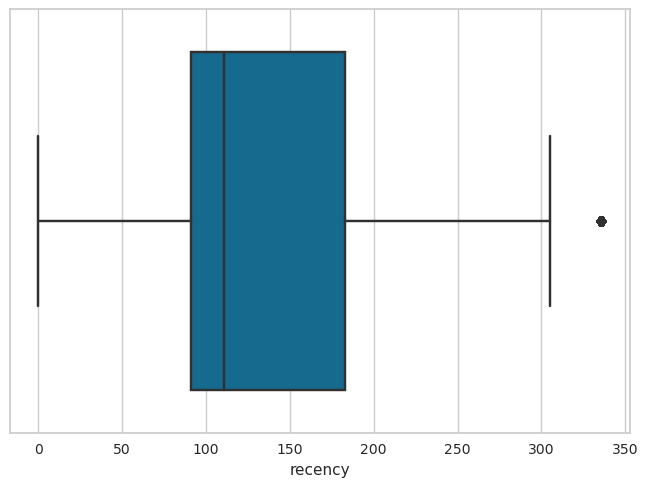

frequency: 


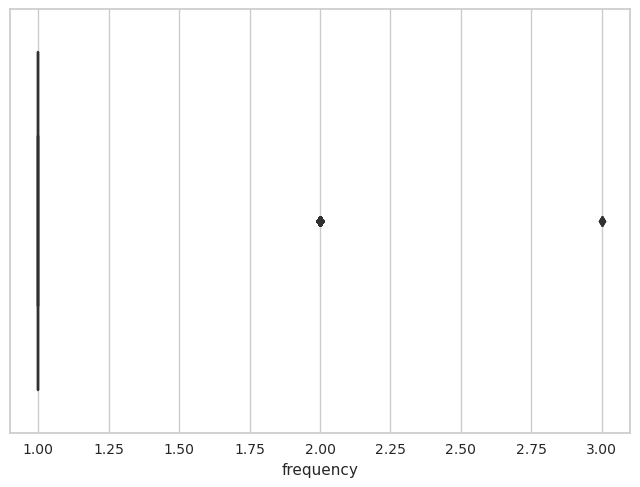

monetary_value: 


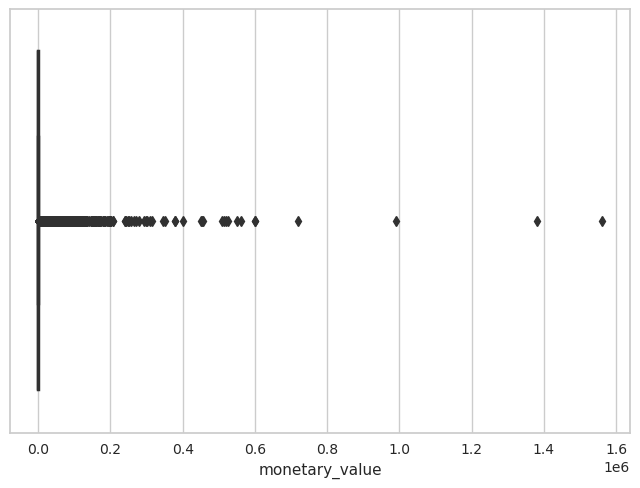

In [39]:
list1 = ['recency','frequency','monetary_value']
for i in list1:
    print(str(i)+': ')
    ax = sns.boxplot(x=rfm[str(i)])
    plt.show()

### Feature Selection

Once calculated all the RMF values, the next step is to choose features suitable for applying K-means algorithm. First we can remove the categorical features such as 'Gender','CustomerID' since the standard k-means algorithm isn't directly applicable to categorical data. We can also remove features 'CustomerDOB' since we already introduce a new feature that represents a cutomer's Age. Although, this analysis is based on the behaviours of the customers, I will be including this new demographic attribute for further analysis which is 'Age'.

1. Age
2. TransactionAmount (INR)
3. CustAccountBalance
4. recency
5. frequency
6. monetary_value

In [40]:
finaldf = rfm[['Age','TransactionAmount (INR)','CustAccountBalance','recency','frequency','monetary_value']]
finaldf.head(3)

,Age,TransactionAmount (INR),CustAccountBalance,recency,frequency,monetary_value
0,33,356.0,120180.54,92,1,356.0
1,24,4750.0,32500.73,74,1,4750.0
2,22,1499.0,24204.49,117,1,1499.0


In [41]:
finaldf.describe()

,Age,TransactionAmount (INR),CustAccountBalance,recency,frequency,monetary_value
count,900303.000000,9.003030e+05,9.003030e+05,900303.000000,900303.000000,9.003030e+05
mean,28.970972,1.298816e+03,8.172914e+04,136.530847,1.001313,1.299010e+03
std,5.512821,5.478012e+03,3.981087e+05,82.703384,0.036302,5.478285e+03
min,0.000000,0.000000e+00,0.000000e+00,0.000000,1.000000,0.000000e+00
25%,25.000000,1.480000e+02,4.267010e+03,91.000000,1.000000,1.480000e+02
50%,28.000000,4.000000e+02,1.479545e+04,111.000000,1.000000,4.000000e+02
75%,32.000000,1.020000e+03,4.750937e+04,183.000000,1.000000,1.020000e+03
max,43.000000,1.560035e+06,4.316556e+07,336.000000,3.000000,1.560035e+06


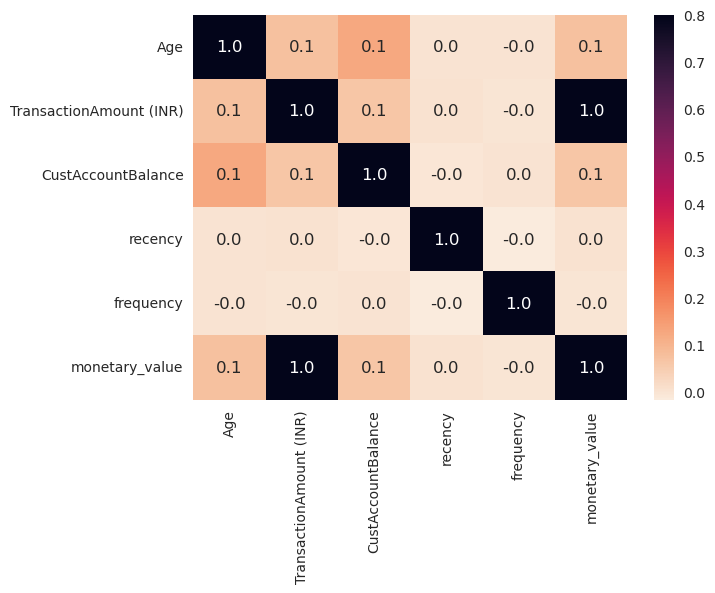

In [42]:
# correlation between features
plt.figure(figsize=(7,5))
correlation=finaldf.corr()
sns.heatmap(correlation,vmin=None,
    vmax=0.8,
    cmap='rocket_r',
    annot=True,
    fmt='.1f',
    linecolor='white',
    cbar=True);

When looking at the correlation between the features I do not see any strong correlation among any of the features. Hence, continue with the above features.

In [43]:
#test

In [44]:
newdf = finaldf.drop_duplicates()
col_names = finaldf.columns.values
features_df = newdf.sample(n=100000,random_state=42).reset_index(drop=True)

Next, I applied the standardscaler to standardize the data to get all the features around the same scale. Since the dataset is huge, I will select a random sample of 10,000 data from the pre-processed data set for further analysis and model building.

In [45]:
scaler = StandardScaler().fit(features_df)
features = scaler.transform(features_df)
scaled_features = pd.DataFrame(features, columns = col_names)

In [46]:
scaled_features.head(3)

,Age,TransactionAmount (INR),CustAccountBalance,recency,frequency,monetary_value
0,-0.909429,-0.264427,-0.086889,0.575317,-0.03566,-0.264453
1,0.542840,-0.239419,-0.203598,-0.898008,-0.03566,-0.239445
2,1.995109,0.289568,4.327432,2.410937,-0.03566,0.289541


### Building the model applying the K-Means algorithm

To find the optimal number of clusters, I am using the widely used 'Elbow Method'.

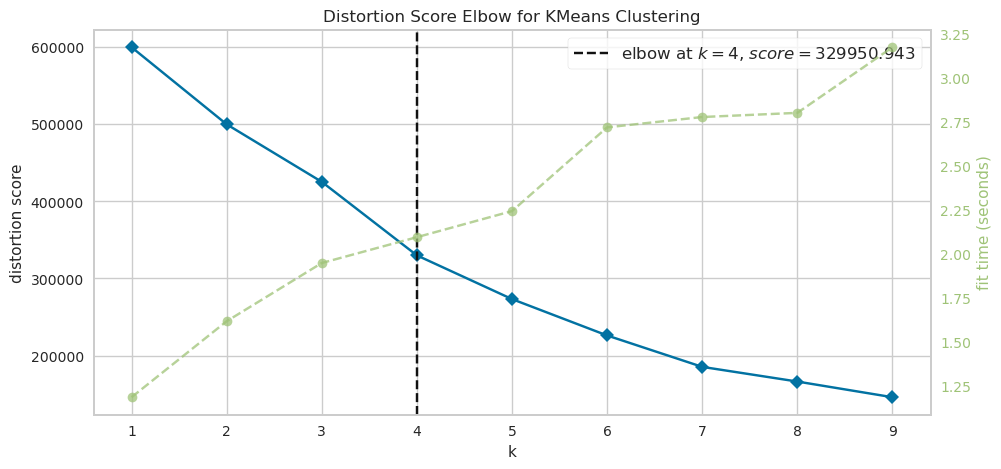

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [47]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10),size=(1080, 500))

visualizer.fit(scaled_features)     # Fit the data to the visualizer
visualizer.show()                   # Finalize and render the figure

Using the Elbow method, we can see that the optimal number of clusters is k=5. Next, we can run the K-means algorithm using k=5 and calculate the Silhouette coefficient metric. Since the dataset is huge, I will select a random sample of 10,000 data from the pre-processed data set.

### Silhouette Score

The Silhouette Score is a way to measure how well data points are clustered. Imagine you have some data and you're trying to group similar points together. The Silhouette Score tells you how close each point is to the other points in its own group compared to the closest neighbouring group.

In simpler terms, it's like giving each data point a grade on how well it fits with its group. If a point is really close to other points in its group and pretty far from points in other groups, it gets a high grade (good silhouette score). But if a point is sort of in the middle, not too close to its group members and not too far from neighbouring groups, it gets a lower grade (lower silhouette score). So, the higher the Silhouette Score is for the whole dataset, the better the clustering is working.

In [48]:
# First, build a model with 5 clusters
kmeans = KMeans(n_clusters = 5, init='k-means++',random_state=42)
kmeans.fit(scaled_features)

# print the silhouette score of this model
print("silhouette_score is :",silhouette_score(scaled_features, kmeans.labels_, metric='euclidean'))

silhouette_score is : 0.3907963607541895


As you can see in the results, the silhouette_score is 0.39, which implies the model is not a bad model. However, we can keep improving this model more. First, let's try to visualize the clusters generated above to get an idea of how the model performs on segmenting the data. For this visualization, I am only using randomly selected 2000 data from the scaled features to build the K-means model.


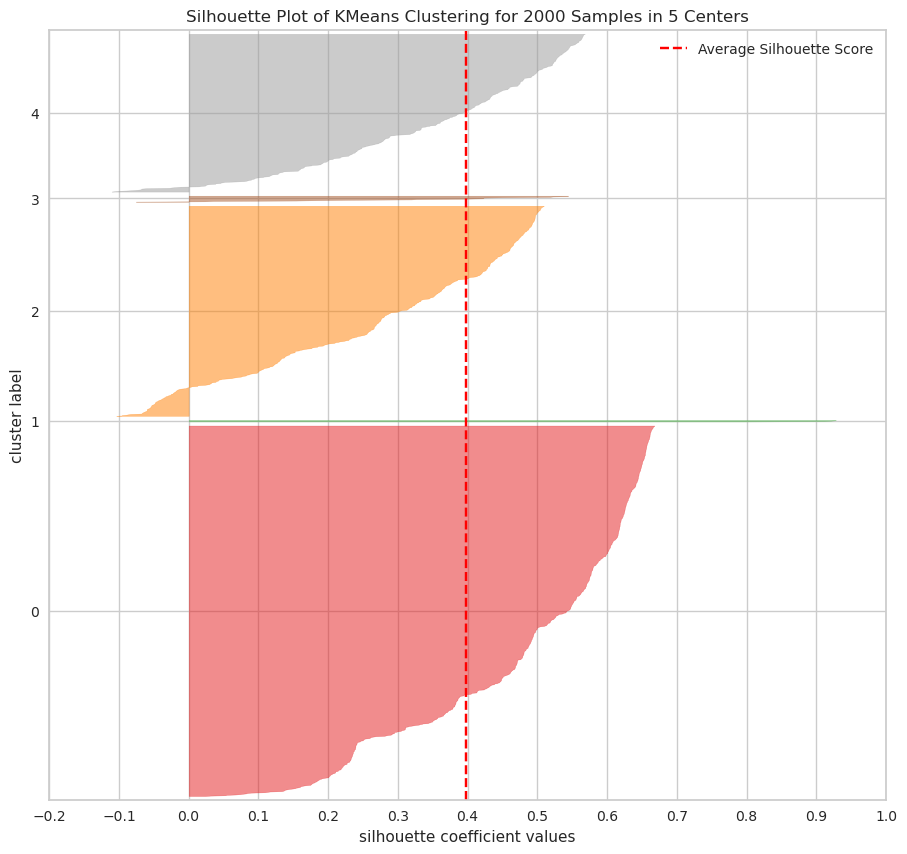

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2000 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [49]:
df_scaled_sample=scaled_features.sample(n=2000,random_state=42).reset_index(drop=True)

kmeans_s = KMeans(n_clusters = 5, init='k-means++',random_state=42)
visualizer = SilhouetteVisualizer(kmeans_s,size=(1080, 1000))

visualizer.fit(df_scaled_sample)    # Fit the data to the visualizer
visualizer.show()   

In [50]:
#kmeans is the first model
clusters = kmeans.fit_predict(scaled_features.iloc[:,1:])
scaled_features["label"] = clusters
scaled_features.head()

,Age,TransactionAmount (INR),CustAccountBalance,recency,frequency,monetary_value,label
0,-0.909429,-0.264427,-0.086889,0.575317,-0.03566,-0.264453,0
1,0.542840,-0.239419,-0.203598,-0.898008,-0.03566,-0.239445,1
2,1.995109,0.289568,4.327432,2.410937,-0.03566,0.289541,0
3,0.542840,-0.239646,-0.184049,2.036567,-0.03566,-0.239672,0
4,-0.727895,-0.264427,-0.198106,0.575317,-0.03566,-0.264453,0


For the cluster visualization, I only used the features 'Age, recency, monetary_value' since they explained the most variance of the data. I also only picked a random sample of 500 data points from each of the clusters for better visualization of the cluster separation.

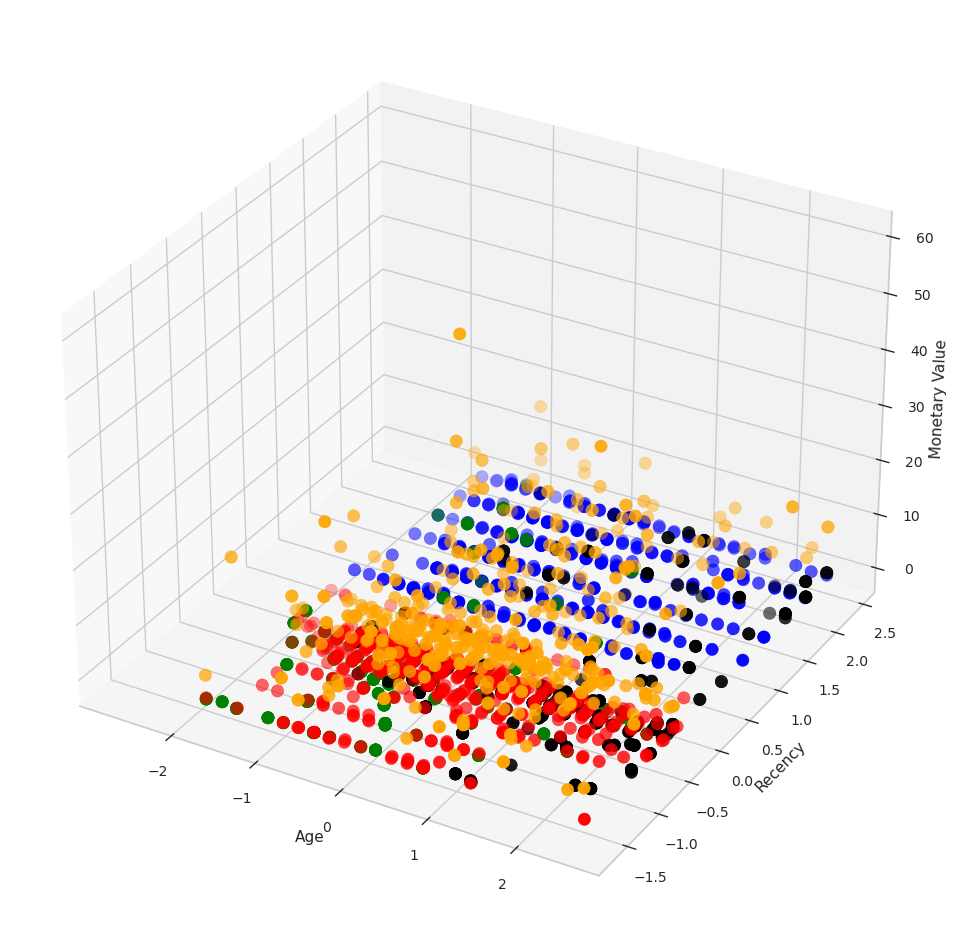

In [51]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

#df = scaled_features.sample(n=5000, replace=False, random_state=1)
df = scaled_features.groupby('label').sample(n=500, replace=True) 

ax.scatter(df.Age[df["label"] == 0], df["recency"][df["label"] == 0], df["monetary_value"][df["label"] == 0], c='blue', s=80)
ax.scatter(df.Age[df["label"] == 1], df["recency"][df["label"] == 1], df["monetary_value"][df["label"] == 1], c='red', s=80)
ax.scatter(df.Age[df["label"] == 2], df["recency"][df["label"] == 2], df["monetary_value"][df["label"] == 2], c='green', s=80)
ax.scatter(df.Age[df["label"] == 3], df["recency"][df["label"] == 3], df["monetary_value"][df["label"] == 3], c='orange', s=80)
ax.scatter(df.Age[df["label"] == 4], df["recency"][df["label"] == 4], df["monetary_value"][df["label"] == 4], c='black', s=80)

ax.set_xlabel("Age")
ax.set_ylabel("Recency")
ax.set_zlabel("Monetary Value")
plt.show()

By looking at the above graph, we can see that the cluster separation is not that promising. Here I only pick the 'Age', 'Recency' and 'monetary_value' since they show the data variation the most. The results of the silhouette score and the above graphs tell us we can improve this model more. In the context of our data with features 'Age', 'Recency', and 'monetary_value', applying PCA can potentially help improve the cluster separation by reducing noise and capturing the most significant patterns of variation.

### Principle component Analysis (PCA)

Principal Component Analysis (PCA) is a widely used technique in machine learning and statistics for reducing the dimensionality of data while preserving as much variance as possible. It achieves this by transforming the original features into a new set of orthogonal (uncorrelated) features called principal components. 

The goal is to retain a subset of principal components that explain a significant portion (e.g., 95% or 99%) of the total variance. We can select the first 'k' components for our model improvement.

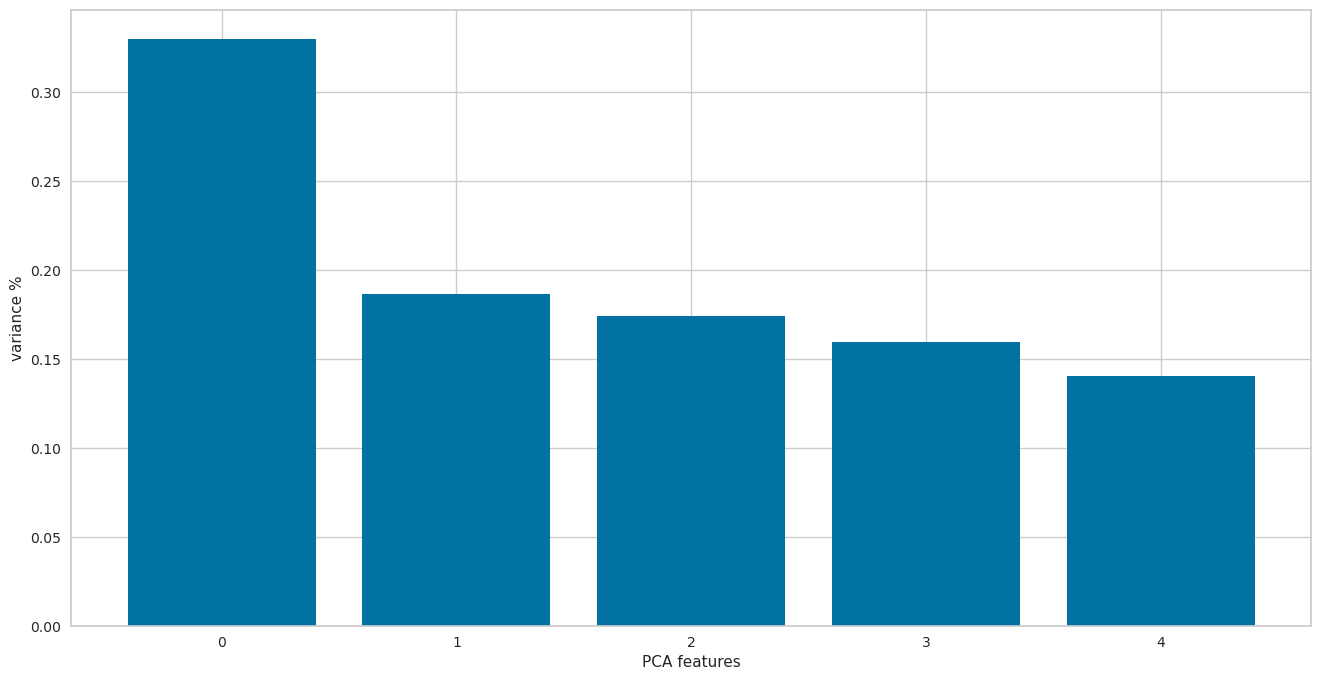

In [52]:
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(scaled_features)

features = range(pca.n_components_)
plt.figure(figsize=(16,8))
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)

Following the PCA results, I am only considering the first two components which explain more than 50% of the dataset variance. Now these two components become the new input features for our clustering model. Next, let's apply the same 'Elbow method' I applied before to find the optimal K.

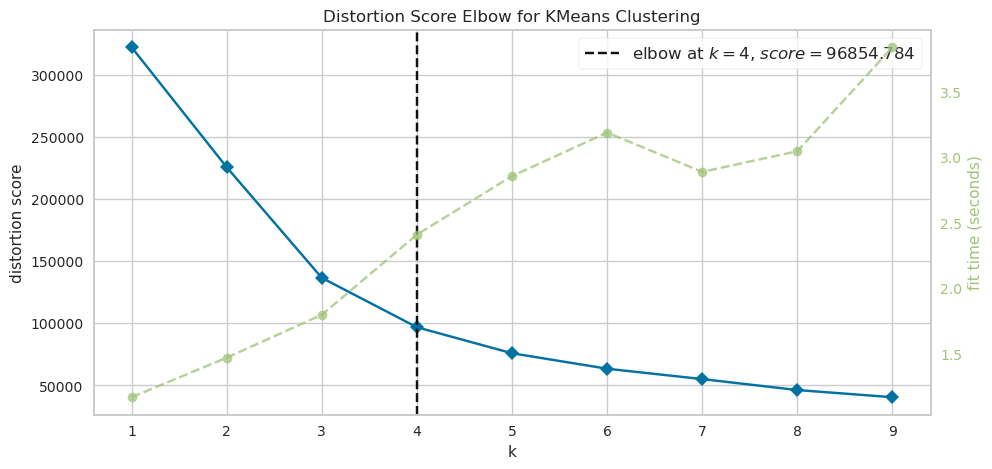

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [53]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10),size=(1080, 500))

visualizer.fit(PCA_components.iloc[:,:2])        # Fit the data to the visualizer
visualizer.show()  

In [54]:
model = KMeans(n_clusters=4, init='k-means++',random_state=42)
model.fit(PCA_components.iloc[:,:2])

# silhouette score
print("silhouette_score is :",silhouette_score(PCA_components.iloc[:,:2], model.labels_, metric='euclidean')) 


silhouette_score is : 0.6492301685074165


Compared to the previous silhouette score which was 0.39, now we have a higher score of 0.64 implying the new model is better than the previous model. For the following visualizations, I am using only a sample of the 'scaled_features' to apply PCA and then to train the K-means model. Let's see how the new features generated from PCA separate the data into clusters. 

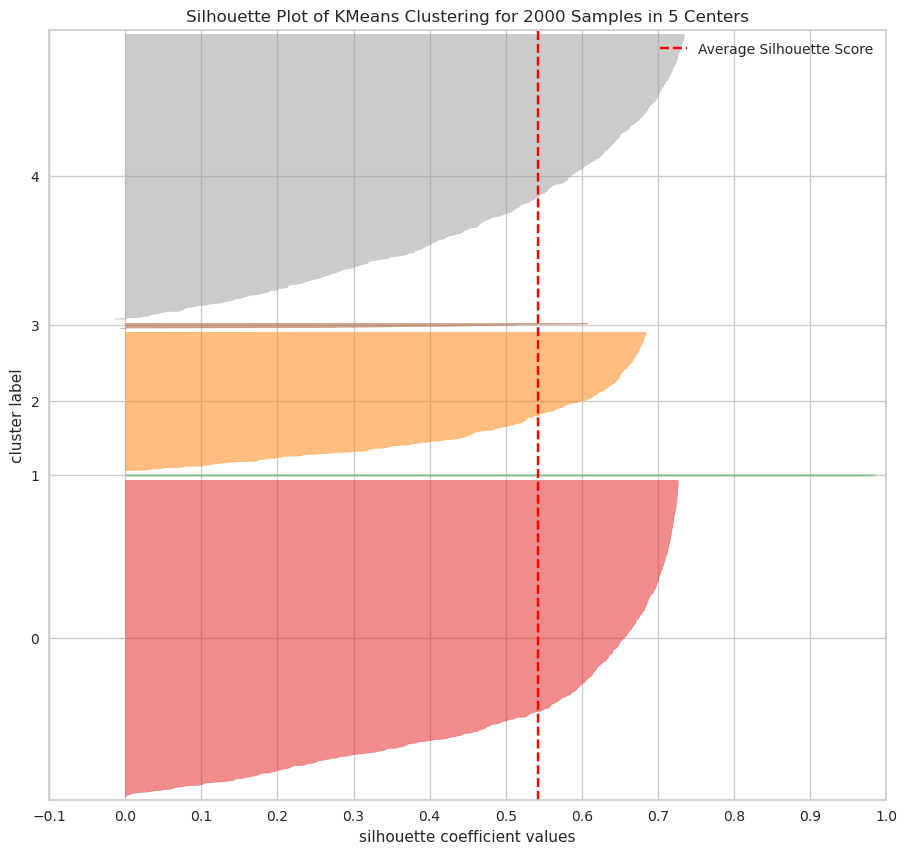

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2000 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [55]:
principalComponents_2 = pca.fit_transform(df_scaled_sample)
PCA_df=pd.DataFrame(principalComponents_2)

model_s = KMeans(n_clusters = 5, init='k-means++',random_state=42)
visualizer = SilhouetteVisualizer(model_s,size=(1080, 1000))

visualizer.fit(PCA_df.iloc[:,:2])    # Fit the data to the visualizer
visualizer.show() 

In [56]:
clusters = model.fit_predict(PCA_components.iloc[:,:2])
scaled_features["new_label"] = clusters
scaled_features.head()

,Age,TransactionAmount (INR),CustAccountBalance,recency,frequency,monetary_value,label,new_label
0,-0.909429,-0.264427,-0.086889,0.575317,-0.03566,-0.264453,0,1
1,0.542840,-0.239419,-0.203598,-0.898008,-0.03566,-0.239445,1,0
2,1.995109,0.289568,4.327432,2.410937,-0.03566,0.289541,0,1
3,0.542840,-0.239646,-0.184049,2.036567,-0.03566,-0.239672,0,1
4,-0.727895,-0.264427,-0.198106,0.575317,-0.03566,-0.264453,0,1


Similar to the previous, for the following visualization I am only using a 500 random sample of the data from each cluster. The new cluster Id is represented by the 'new_label'.

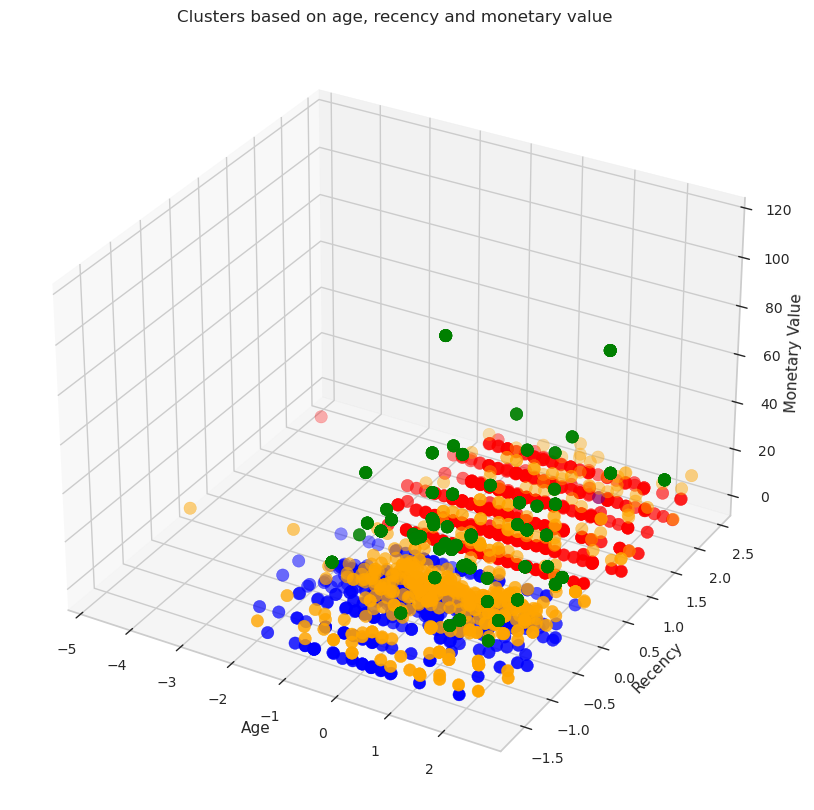

In [57]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

df = scaled_features.groupby('new_label').sample(n=500, replace=True) 

ax.scatter(df.Age[df["new_label"] == 0],df["recency"][df["new_label"] == 0], df["monetary_value"][df["new_label"] == 0], c='blue', s=80)
ax.scatter(df.Age[df["new_label"] == 1],df["recency"][df["new_label"] == 1], df["monetary_value"][df["new_label"] == 1], c='red', s=80)
ax.scatter(df.Age[df["new_label"] == 2], df["recency"][df["new_label"] == 2], df["monetary_value"][df["new_label"] == 2], c='green', s=80)
ax.scatter(df.Age[df["new_label"] == 3],df["recency"][df["new_label"] == 3], df["monetary_value"][df["new_label"] == 3], c='orange', s=80)
ax.scatter(df.Age[df["new_label"] == 4], df["recency"][df["new_label"] == 4], df["monetary_value"][df["new_label"] == 4], c='black', s=80)

ax.set_xlabel("Age")
ax.set_ylabel("Recency")
ax.set_zlabel("Monetary Value")

#plt.savefig('Cust_seg_01.png')
plt.title('Clusters based on age, recency and monetary value')

plt.show()

By looking at the above graph, we can conclude that the cluster separation provided by the new model is more compelling than the previous model. We can see the clusters better now. Hence, for this customer segmentation activity, I am gonna use the second model that applies PCA to select new features. 

### Cluster Analysis and Customer Segmentation

Now that we built the model, and obtained the results we can analyse the clusters and interpret the results for customer segmentation. First, I map the clusters back to their original dataset.

In [58]:
pred = model.predict(PCA_components.iloc[:,:2])
features_df['cluster'] = pred
avg_df = features_df.groupby(['cluster'], as_index=False).mean()
avg_df.head(3)

,cluster,Age,TransactionAmount (INR),CustAccountBalance,recency,frequency,monetary_value
0,0,28.989321,914.923320,79658.840432,93.882573,1.001716,915.082650
1,1,28.932583,991.330653,58220.247394,259.491928,1.000000,991.330653
2,2,32.333333,112665.933684,946078.160351,141.543860,1.000000,112665.933684


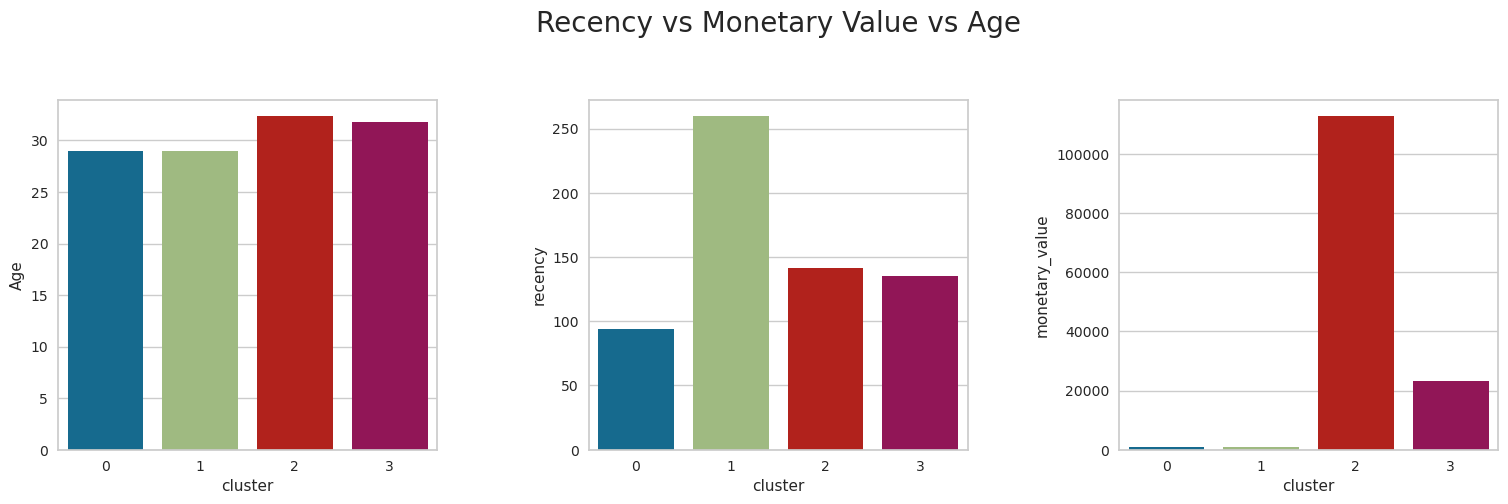

In [59]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
sns.barplot(x='cluster',y='Age',data=avg_df ,ax=ax[0])
sns.barplot(x='cluster',y='recency',data=avg_df, ax=ax[1])
sns.barplot(x='cluster',y='monetary_value',data=avg_df, ax=ax[2])
plt.suptitle('Recency vs Monetary Value vs Age',fontsize=20)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.8, 
                    wspace=0.4, 
                    hspace=0.4)

fig.tight_layout()
plt.show()

From the above graphs, we can conclude the following for each cluster.

1. Cluster 0: Shows low average recency and low monetary value with an average customer age of around 28
2. Cluster 1: Shows high average recency and low monetary value with an average customer age of around 28
3. Cluster 2: Shows moderate average recency and high monetary value with an average customer age of around 33
4. Cluster 3: Shows moderate average recency and moderate monetary value with an average customer age of around 32